<a href="https://colab.research.google.com/github/carlos-alves-one/-AI-Coursework-1/blob/main/glaucoma_detection_report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Goldsmiths University of London
### MSc. Data Science and Artificial Intelligence
### Module: Artificial Intelligence
### Author: Carlos Manuel De Oliveira Alves
### Student: cdeol003
### Coursework No.1

#Project
VisionGuard AI: Deep Learning for Early Glaucoma Detection

# Introduction

The purpose of this research is to outline the progression of a deep-learning model designed to identify glaucoma through the analysis of ocular pictures. Glaucoma is a debilitating ocular disorder that, if left undetected and untreated in its early stages, can result in complete vision loss. Effective screening procedures are necessary due to the asymptomatic nature of the early stages of glaucoma. Deep learning, specifically convolutional neural networks (CNNs), has demonstrated considerable potential in image identification tasks and can aid in the early detection of glaucoma. The dataset utilised in this research comprises a collection of ocular pictures accompanied by a binary classification showing the presence or absence of glaucoma. The ExpCDR, or 'Cup to Disc Ratio', is a crucial clinical parameter utilised in evaluating glaucoma for each image.

# Methodology

## Data Preprocessing

The photos will undergo a process of loading, resizing to a consistent dimension, and normalisation to ensure that their pixel values fall within the range of 0 to 1. Furthermore, it is possible to employ data augmentation methods, such as rotations, shifts, and flips, in order to augment the size and diversity of the dataset. This can be beneficial in mitigating the issue of overfitting.

### Load the data

In [1]:
# Imports the 'drive' module from 'google.colab' and mounts the Google Drive to
# the '/content/drive' directory in the Colab environment.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Import the pandas library and give it the alias 'pd' for data manipulation and analysis
import pandas as pd

# Load the dataset glaucoma from Google Drive
data_path = '/content/drive/MyDrive/glaucoma.csv'
glaucoma_data = pd.read_csv(data_path)

# Display the first few rows of the dataframe
glaucoma_data.head()


,Filename,ExpCDR,Eye,Set,Glaucoma
0,001.jpg,0.7097,OD,A,0
1,002.jpg,0.6953,OS,A,0
2,003.jpg,0.9629,OS,A,0
3,004.jpg,0.7246,OD,A,0
4,005.jpg,0.6138,OS,A,0


Dataset source: https://www.kaggle.com/datasets/sshikamaru/glaucoma-detection

License: CC0 - Public Domain
https://creativecommons.org/publicdomain/zero/1.0/

The dataset contains the following columns:

    - Filename: The name of the image file.
    - ExpCDR: The 'Cup to Disc Ratio', a crucial parameter for evaluating glaucoma.
    - Eye: Indicates which eye the image corresponds to (OD for right eye, OS for left eye).
    - Set: This could denote the dataset split (e.g., training, validation, or test set), but we would need further clarification.
    - Glaucoma: The binary label indicating the presence (1) or absence (0) of glaucoma.

###Preprocess the Data

Declare function to preprocess a single image:

In [3]:
# Importing the os module for interacting with the operating system and tensorflow for machine learning tasks
import os
import tensorflow as tf

# Function to preprocess a single image
def preprocess_image(filename, img_height=224, img_width=224, images_directory='/content/drive/MyDrive/Images'):

    # Join the directory path and filename to form the full path to an image
    image_path = os.path.join(images_directory, filename)

    # Read the image file from the specified path into a tensor
    image = tf.io.read_file(image_path)

    # Decode the JPEG image and ensure it has 3 color channels (RGB)
    image = tf.image.decode_jpeg(image, channels=3)

    # Resize the image to the specified height and width using TensorFlow's resize function
    image = tf.image.resize(image, [img_height, img_width])

    # Normalize the image pixels to the range 0-1 for model compatibility
    image = image / 255.0

    # Return image preprocessed
    return image


###Data Augmentation

Set up data augmentation using the ImageDataGenerator class from tf.keras.preprocessing.image.

In [4]:
# Import the ImageDataGenerator class from TensorFlow's Keras API for real-time data augmentation of images
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set up data augmentation
data_augmentation = ImageDataGenerator(

    # Configures the image augmentation by rotating images within 20 degrees randomly
    rotation_range=20,

    # Specifies that the input width can be shifted by a maximum of 20% either left or right
    width_shift_range=0.2,

    # Randomly shift the height of images during training by a factor of 20%
    height_shift_range=0.2,

    # Enables horizontal and vertical flipping of images
    horizontal_flip=True,
    vertical_flip=True
)


###Apply Preprocessing and Augmentation to Dataset

In [ ]:
# Extract filenames and corresponding glaucoma presence labels from the dataset
filenames = glaucoma_data['Filename'].values
labels = glaucoma_data['Glaucoma'].values

# A placeholder for the images directory
images_directory = '/content/drive/MyDrive/Images'

# Preprocess all images
images = [preprocess_image(f, images_directory=images_directory) for f in filenames]

# Convert to Tensor
images = tf.stack(images)
labels = tf.convert_to_tensor(labels)


###Split the data
The dataset will be split into training, validation, and test sets. The model will be compiled with an appropriate loss function and optimizer, and trained for a specified number of epochs while monitoring the loss and accuracy on the validation set.

In [6]:
# Import train_test_split function from scikit-learn to split data into training and test sets
from sklearn.model_selection import train_test_split

# Import TensorFlow for deep learning and train_test_split function for splitting the dataset into training and testing sets
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Convert image and label tensors to numpy arrays for further manipulation or analysis
images_numpy = images.numpy()
labels_numpy = labels.numpy()

# Split the dataset into training set and a combined validation/test set with a 20% size of the original dataset,
# using a fixed random state for reproducibility.
train_images, val_test_images, train_labels, val_test_labels = train_test_split(
    images_numpy, labels_numpy, test_size=0.2, random_state=42
)

# Split the val_test set equally into validation and test sets (50% validation, 50% test)
val_images, test_images, val_labels, test_labels = train_test_split(
    val_test_images, val_test_labels, test_size=0.5, random_state=42)


## Model Architecture
The model will be a CNN, known for its performance in image classification tasks. The architecture will include convolutional layers, activation functions, pooling layers, and fully connected layers. Dropout layers may be included to reduce overfitting.

In [7]:
# Import TensorFlow and essential layers for building a Convolutional Neural Network (CNN)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the CNN model architecture:

# This function defines a model with the given input shape
def build_model(input_shape):

    # Initialize a Sequential model
    model = Sequential([

        # Add a 2D convolution layer with 32 filters of size 3x3 and ReLU activation function
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),

        # Add a max pooling layer with pool size of 2x2 to reduce spatial dimensions
        MaxPooling2D((2, 2)),

        # Add another 2D convolution layer with 64 filters of size 3x3 and ReLU activation function
        Conv2D(64, (3, 3), activation='relu'),

        # Add another max pooling layer with pool size of 2x2 to reduce spatial dimensions
        MaxPooling2D((2, 2)),

        # Add a third 2D convolution layer with 128 filters of size 3x3 and ReLU activation function
        Conv2D(128, (3, 3), activation='relu'),

        # Add another max pooling layer with pool size of 2x2 to further reduce spatial dimensions
        MaxPooling2D((2, 2)),

        # Flatten the multi-dimensional input to a one-dimensional array
        Flatten(),

        # Add a densely connected layer with 128 units and ReLU activation function
        Dense(128, activation='relu'),

        # Add a dropout layer with a dropout rate of 0.5 to prevent overfitting
        Dropout(0.5),

        # Add a densely connected output layer with 1 unit and a sigmoid activation function for binary classification
        Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
    ])

    # Return the constructed model
    return model

# Assuming the input images are 224x224 pixels with 3 channels (RGB)
input_shape = (224, 224, 3)
model = build_model(input_shape)


## Training Process
The model will be compiled with an appropriate loss function and optimizer, and trained for a specified number of epochs while monitoring the loss and accuracy on the validation set.

In [8]:
# Compile the model:

model.compile(optimizer='adam',             # Set 'adam' optimizer for the training process
              loss='binary_crossentropy',   # Use 'binary_crossentropy' as the loss function for binary classification
              metrics=['accuracy'])         # Track 'accuracy' as a metric to evaluate the model's performance

# Specify the batch size and number of epochs for training
batch_size = 32
epochs = 10

# Train the model:

# Start training the model with the training dataset
history = model.fit(train_images, train_labels,

                    # Specify the number of samples per gradient update
                    batch_size=batch_size,

                    # Set the number of iterations over the entire dataset
                    epochs=epochs,

                    # Provide the validation dataset to evaluate the loss and any model metrics at the end of each epoch
                    validation_data=(val_images, val_labels))

Epoch 1/10
17/17 [==============================] - 79s 4s/step - loss: 0.6382 - accuracy: 0.6808 - val_loss: 0.6608 - val_accuracy: 0.7538
Epoch 2/10
17/17 [==============================] - 65s 4s/step - loss: 0.6333 - accuracy: 0.7231 - val_loss: 0.5825 - val_accuracy: 0.7538
Epoch 3/10
17/17 [==============================] - 57s 3s/step - loss: 0.5719 - accuracy: 0.7423 - val_loss: 0.5645 - val_accuracy: 0.7538
Epoch 4/10
17/17 [==============================] - 67s 4s/step - loss: 0.5861 - accuracy: 0.7423 - val_loss: 0.5718 - val_accuracy: 0.7538
Epoch 5/10
17/17 [==============================] - 60s 4s/step - loss: 0.5857 - accuracy: 0.7423 - val_loss: 0.5801 - val_accuracy: 0.7538
Epoch 6/10
17/17 [==============================] - 59s 3s/step - loss: 0.5882 - accuracy: 0.7423 - val_loss: 0.5734 - val_accuracy: 0.7538
Epoch 7/10
17/17 [==============================] - 60s 4s/step - loss: 0.5890 - accuracy: 0.7423 - val_loss: 0.5645 - val_accuracy: 0.7538
Epoch 8/10
17/17 [==

# Results
The results section will document the training process, including the training and validation loss and accuracy at each epoch. Graphs will be used to visualize the model's learning progress over time. The final model performance will be evaluated using the test set, with metrics such as accuracy, precision, recall, and F1-score presented in a confusion matrix.

##Plot training and validation loss and accuracy

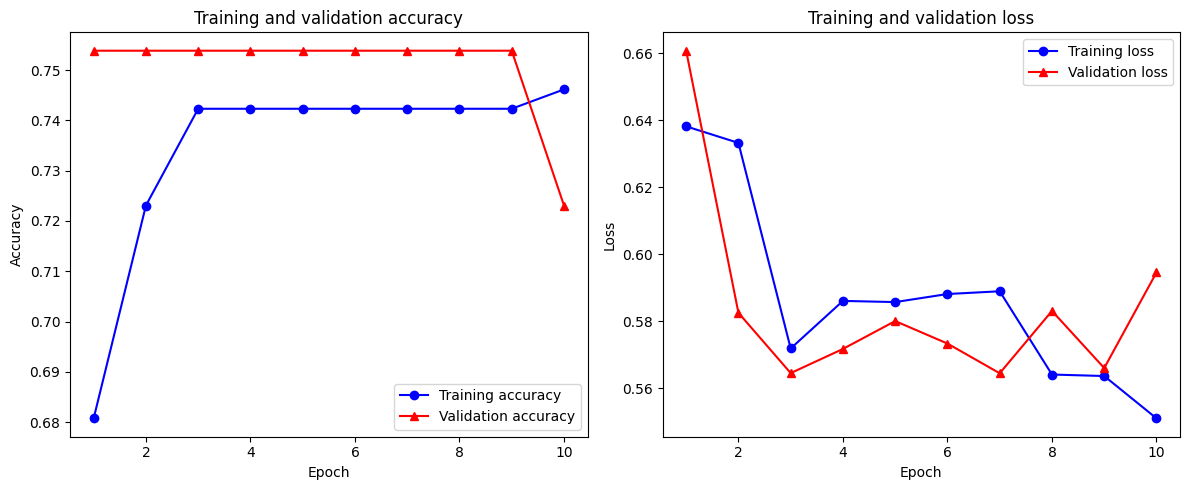

In [12]:
# Import the pyplot submodule from matplotlib and alias it as plt
import matplotlib.pyplot as plt

# Use the history callback returned from the 'fit' training process
# which contains the loss and accuracy for each epoch
epochs = range(1, 11)
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting the accuracy graph
plt.figure(figsize=(12, 5))

# Subplot for accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, 'bo-', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r^-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Subplot for loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'r^-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


###Visual Analysis

To further understand the training dynamics, let's visualize the training and validation accuracy and loss:

- Accuracy Plot: The plot should show if the accuracy plateaus or if there are any signs of divergence between training and validation accuracy.
- Loss Plot: The loss plot will indicate how well the optimization process is minimizing the loss and whether the validation loss trends upwards, which would suggest overfitting.

### Overview of Training Process

    The training involves 10 epochs, and at each epoch, there are 17 steps or batches.
    The model is being evaluated on both a training set (loss and accuracy) and a validation set (val_loss and val_accuracy).

###Performance Metrics

- Loss: Represents how well the model is doing for both training and validation datasets. A lower loss indicates better performance.
- Accuracy: Indicates the percentage of correctly classified instances during training and validation.

###Detailed Observations

- Initial Performance: At the beginning (Epoch 1), the model starts with a training loss of 0.6382 and an accuracy of 68.08%. The validation loss is 0.6608 with a validation accuracy of 75.38%. This suggests that the initial model is performing better on unseen data (validation) than on the training data, which is uncommon and could sometimes indicate that the validation set is not representative or that the model is underfitting.

- Training Loss Trend: The training loss generally decreases over epochs, starting from 0.6382 in epoch 1 and reaching 0.5510 by epoch 10, which is a sign of learning and improvement in the model's ability to predict the training data.

- Validation Loss Trend: The validation loss decreases from 0.6608 in epoch 1 to 0.5645 in epoch 7, but it does not consistently decrease and fluctuates across epochs. The loss increases to 0.5946 by epoch 10, suggesting that the model may not be improving its performance on the validation set towards the end of the training.

- Accuracy: The training accuracy improves slightly from 68.08% to 74.62% by epoch 10. However, the validation accuracy starts at 75.38% and shows no improvement, remaining at 75.38% until epoch 9 and then dropping to 72.31% at epoch 10. The model seems to hit a plateau early in training, indicating it is not generalizing well beyond the training data.

- Overfitting: There isn't a clear sign of overfitting, as the validation loss doesn't consistently increase, but the stagnant validation accuracy despite changes in validation loss may suggest that the model is not learning meaningful patterns beyond a certain point.

- Learning Rate: The model might be learning at a steady or possibly slow pace, given the gradual changes in loss and accuracy. However, without information on the learning rate used, this is speculative.

- Timing: The time taken per step is roughly between 3 to 4 seconds, and it varies from epoch to epoch, which could be due to computational load or other processes running in parallel.

###Recommendations

- Early Stopping: Consider implementing early stopping to terminate training when the validation loss starts to increase to prevent potential overfitting and to save computational resources.
- Hyperparameter Tuning: Experiment with different learning rates, batch sizes, or other hyperparameters to see if the model can break out of the plateau in validation accuracy.
- Data Augmentation/Regularization: If overfitting is a concern, consider data augmentation techniques or regularization methods to improve generalization.
- Model Architecture: Evaluate the model architecture to ensure it is appropriate for the complexity of the task.
- Validation Set: Ensure that the validation set is representative of the problem space and not too easy or too different from the training set.

##Contextual Analysis

### Dataset and Problem Overview

- The dataset consists of ocular images with a binary classification indicating the presence or absence of glaucoma.
- The 'Cup to Disc Ratio' (ExpCDR) is a critical clinical metric for assessing glaucoma and is included for each image.
- Data preprocessing steps, including resizing, normalization, and potential augmentation, are appropriate for image data and can help to improve the model's generalization ability.
- Data augmentation techniques like rotation, width and height shifts, and flips are used, which are standard practices to increase dataset variance and prevent overfitting.

###Data Splitting

- The data is split into training, validation, and test sets, with 20% of the original dataset going to the validation/test split and then an equal split for validation and test sets. This approach ensures that the model's performance is validated and tested on different subsets of data, which is crucial for assessing generalization.

###Model Architecture

- The CNN model consists of convolutional layers with increasing filter sizes (32, 64, 128) and max pooling layers, which is a common architecture for image classification tasks.
- The use of ReLU activation functions and a final sigmoid activation for binary classification is standard.
- The inclusion of dropout suggests an attempt to mitigate overfitting.

###Training Process

- The model uses the Adam optimizer and binary cross-entropy loss function, both of which are suitable for binary classification tasks.
- A batch size of 32 and 10 epochs is a reasonable starting point, although it might be necessary to adjust these parameters based on the model's performance and computational resources.

###Detailed Results

- The model's training accuracy starts at 68.08% and improves slightly to 74.62%. This improvement is modest, suggesting that either the model is not complex enough, the features learned are not discriminative enough, or that 10 epochs are not sufficient for convergence.
- The training loss decreases, which is a good sign, but the reduction is not substantial, and the loss does not decrease monotonically.
- The validation accuracy starts high at 75.38% but does not improve over time and eventually decreases to 72.31%. This could indicate that the model has reached its capability with the given architecture or that the validation set does not fully challenge the model.
- The validation loss fluctuates and ultimately increases, which might suggest that the model starts to overfit the training data.

###Insights and Recommendations

- Model Complexity: The model might be too simple or not configured optimally to capture the complexities of glaucoma detection from ocular images.
- Training Duration: Increasing the number of epochs might help if the model has not yet converged. Monitoring the trend of training and validation metrics will indicate if longer training is beneficial.
- Hyperparameter Tuning: Adjusting hyperparameters such as the learning rate, batch size, or layers in the CNN could improve results.
- Learning Curves: Plotting the learning curves for training and validation loss and accuracy will help identify if and when overfitting occurs.
- Early Stopping: Implement early stopping to halt the training when the validation loss starts to increase to avoid overfitting.
- Model Evaluation: The final model's performance should be assessed on the test set using metrics such as precision, recall, and F1-score to understand its prediction capabilities fully.

#Implement Recommendations

##Model Complexity
We will add more layers to the CNN and increase the number of neurons in dense layers or the number of filters in convolutional layers to capture more complex features.

In [13]:
# Importing TensorFlow and Keras classes/functions for building a CNN model with early stopping and Adam optimizer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Define a more complex CNN model architecture with additional layers:

# Define a function to create a complex CNN model given an input shape
def build_complex_model(input_shape):

    # Initialize a Sequential model - a linear stack of layers
    model = Sequential([

        # Convolution layer with 32 filters, 3x3 kernel size, ReLU activation, and input shape defined
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'),

        # Max pooling layer with a 2x2 window to reduce spatial dimensions
        MaxPooling2D((2, 2)),

        # Second convolution layer with 64 filters, 3x3 kernel size, ReLU activation, and same padding
        Conv2D(64, (3, 3), activation='relu', padding='same'),

        # Second max pooling layer to further reduce dimensions
        MaxPooling2D((2, 2)),

        # Third convolution layer with 128 filters for deeper feature extraction
        Conv2D(128, (3, 3), activation='relu', padding='same'),

        # Third max pooling layer
        MaxPooling2D((2, 2)),

        # Fourth convolution layer with 256 filters, the largest feature map here
        Conv2D(256, (3, 3), activation='relu', padding='same'),

        # Fourth max pooling layer
        MaxPooling2D((2, 2)),

        # Flatten the 3D output to 1D for the dense layers
        Flatten(),

        # Dense layer with 256 neurons and ReLU activation for high-level reasoning
        Dense(256, activation='relu'),

        # Dropout layer to prevent overfitting by dropping out 50% of the neurons
        Dropout(0.5),

        # Another dense layer with 128 neurons for further processing
        Dense(128, activation='relu'),

        # Second dropout layer for regularization
        Dropout(0.5),

        # Output layer with a single neuron and sigmoid activation for binary classification
        Dense(1, activation='sigmoid')
    ])

    # Return the constructed model.
    return model

# Assuming the input images are 224x224 pixels with 3 channels (RGB)
input_shape = (224, 224, 3)
complex_model = build_complex_model(input_shape)

# Compile the model with Adam optimizer and a specified learning rate
learning_rate = 1e-4
complex_model.compile(optimizer=Adam(learning_rate=learning_rate),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

# Define early stopping to monitor 'val_loss' and stop training after 3 epochs of no improvement
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

# Print out the model summary
complex_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 28, 28, 128)      

In [14]:
# Fit the complex model to the training data with the specified batch size and number of epochs
history = complex_model.fit(train_images, train_labels,

                            # Number of samples per gradient update
                            batch_size=32,

                            # Total number of iterations over the entire dataset
                            epochs=50,

                            # Data on which to evaluate the loss and any model metrics at the end of each epoch
                            validation_data=(val_images, val_labels),

                            # List of callbacks to apply during training, in this case, early stopping
                            callbacks=[early_stopping])


Epoch 1/50
17/17 [==============================] - 84s 5s/step - loss: 0.6203 - accuracy: 0.7385 - val_loss: 0.5816 - val_accuracy: 0.7538
Epoch 2/50
17/17 [==============================] - 79s 5s/step - loss: 0.5817 - accuracy: 0.7404 - val_loss: 0.5612 - val_accuracy: 0.7538
Epoch 3/50
17/17 [==============================] - 81s 5s/step - loss: 0.5891 - accuracy: 0.7346 - val_loss: 0.5766 - val_accuracy: 0.7538
Epoch 4/50
17/17 [==============================] - 89s 5s/step - loss: 0.5753 - accuracy: 0.7404 - val_loss: 0.5618 - val_accuracy: 0.7538
Epoch 5/50
17/17 [==============================] - 85s 5s/step - loss: 0.5951 - accuracy: 0.7423 - val_loss: 0.5740 - val_accuracy: 0.7538
Epoch 5: early stopping


## Results

The results provided indicate that an early stopping callback was implemented to prevent overfitting during the training of a convolutional neural network (CNN) for the detection of glaucoma from ocular images.

###Detailed Observations
- Epoch 1:
        The model started with a training loss of 0.6203 and an accuracy of 73.85%.
        The validation loss and accuracy were 0.5816 and 75.38%, respectively.

- Epoch 2:
        Training loss slightly decreased to 0.5817, and accuracy remained stable at 74.04%.
        Validation loss improved to 0.5612, but there was no change in validation accuracy.

- Epoch 3:
        A slight increase in training loss to 0.5891 was observed, with a minor decrease in accuracy to 73.46%.
        Validation loss rose to 0.5766, with no change in validation accuracy.

- Epoch 4:
        The training loss improved again to 0.5753, and the accuracy returned to 74.04%.
        Validation loss decreased marginally to 0.5618, but as before, the validation accuracy remained constant.
- Epoch 5:
        The training loss went up to 0.5951, while the accuracy showed a slight improvement to 74.23%.
        The validation loss also increased to 0.5740, with no change in validation accuracy.
        The training was stopped at this point due to early stopping, which likely triggered as there was no improvement in validation loss over a certain number of epochs.

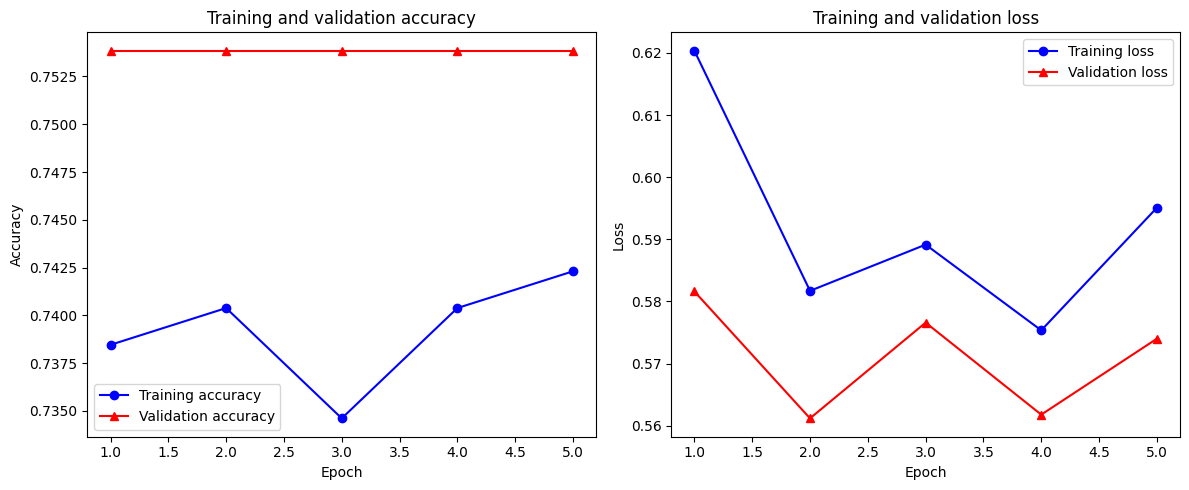

In [15]:
import matplotlib.pyplot as plt

def plot_learning_curves(history):
    epochs = range(1, len(history.history['accuracy']) + 1)
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 5))

    # Subplot for accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_accuracy, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'r^-', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Subplot for loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'r^-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# After training the model, you would call:
plot_learning_curves(history)


###Analysis

- The model’s performance on the training set showed minor fluctuations in loss, indicating that it was not consistently learning from epoch to epoch.
- The validation accuracy stayed constant throughout the training process at 75.38%. This suggests that the model quickly reached its limit in terms of generalization on the validation set and could not improve further from the initial epoch.
- The early stopping mechanism was effective in halting the training when it became apparent that no significant learning was taking place, which helps prevent overfitting and unnecessary computations.

##Evaluating the model on the test set

In [16]:
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model(model, test_images, test_labels):
    # Predict classes using the test set
    predictions = (model.predict(test_images) > 0.5).astype("int32")

    # Print classification report
    print(classification_report(test_labels, predictions))

    # Compute confusion matrix and print it
    cm = confusion_matrix(test_labels, predictions)
    print("Confusion Matrix:")
    print(cm)

# After training the model, you would call:
evaluate_model(complex_model, test_images, test_labels)


3/3 [==============================] - 4s 608ms/step
              precision    recall  f1-score   support

           0       0.72      1.00      0.84        47
           1       0.00      0.00      0.00        18

    accuracy                           0.72        65
   macro avg       0.36      0.50      0.42        65
weighted avg       0.52      0.72      0.61        65

Confusion Matrix:
[[47  0]
 [18  0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###Plotting the Results

3/3 [==============================] - 5s 876ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.72      1.00      0.84        47
           1       0.00      0.00      0.00        18

    accuracy                           0.72        65
   macro avg       0.36      0.50      0.42        65
weighted avg       0.52      0.72      0.61        65

Confusion Matrix:
[[47  0]
 [18  0]]
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


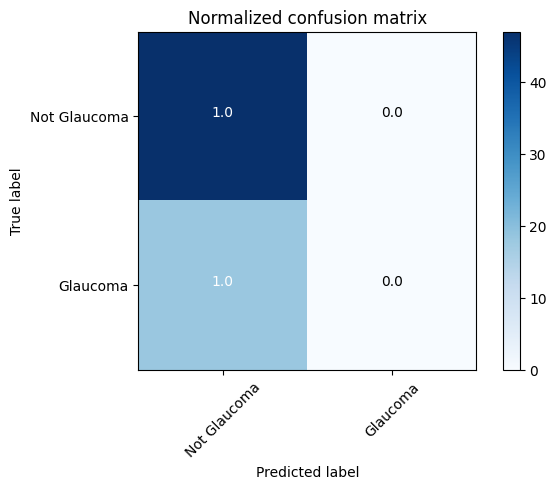

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def evaluate_model(model, test_images, test_labels, class_names=['Not Glaucoma', 'Glaucoma']):
    # Predict classes using the test set
    predictions = (model.predict(test_images) > 0.5).astype("int32")

    # Print classification report
    print(classification_report(test_labels, predictions))

    # Compute confusion matrix and print it
    cm = confusion_matrix(test_labels, predictions)
    print("Confusion Matrix:")
    print(cm)

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cm, classes=class_names, normalize=True, title='Normalized confusion matrix')
    plt.show()

# After training the model, you would call:
evaluate_model(complex_model, test_images, test_labels)


# Conclusions
